In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from tinygp import kernels
from HeaderP import *

jax.config.update("jax_enable_x64", True)
def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)

In [2]:

M67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Age_err'] = oc['AGE_err']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])
oc['Prot_log'] = np.log10(oc['Prot'])
uniqage = oc['Age'].unique()


In [3]:
min(oc['Age_err'])

0.01

71537
64359
1.4


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/3259487285.py:26: RankWarning: Polyfit may be poorly conditioned
  p = fitpoints(teff_med, prot_med, 51)


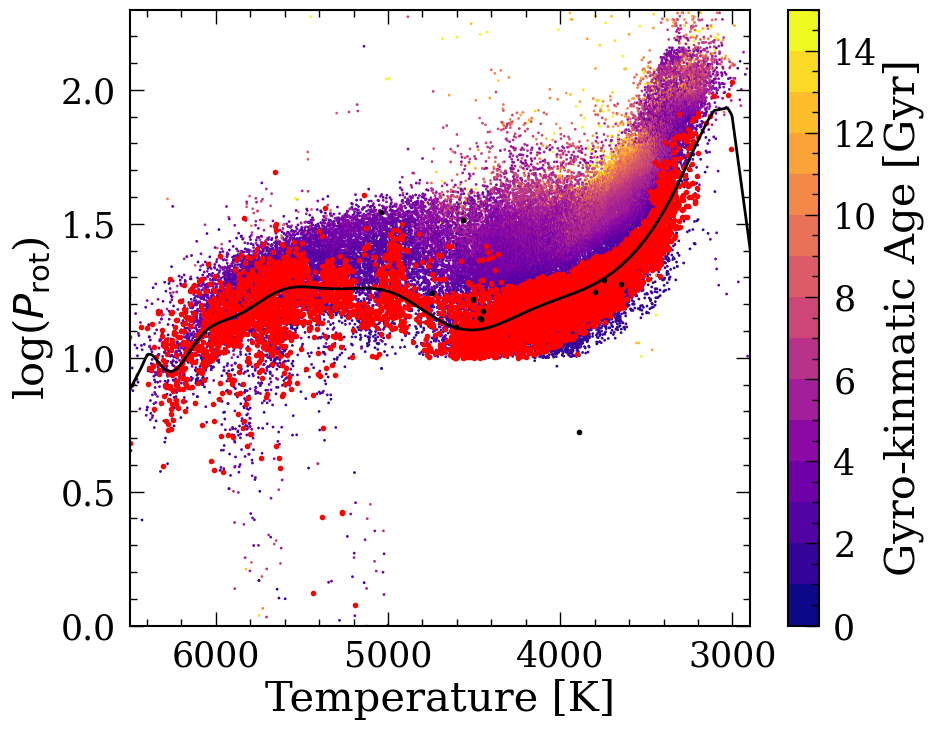

In [4]:
plt.figure(figsize=(10,8))
ztf = pd.read_csv('AllztfAge.csv')
print(len(ztf))
ztf = ztf.loc[ztf['Prot']<200]
ztf['kin_age'] = ztf['kin_age']-0.5
ztf = ztf.loc[ztf['kin_age']>1.4].reset_index(drop=True)

print(len(ztf))

plt.scatter(ztf['teff_calc'], ztf['Prot_log'], c=ztf['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=1)


selage = uniqage[4]
print(selage)
m = abs(ztf['kin_age']-0.5-selage)<0.2
plt.plot(ztf['teff_calc'][m], ztf['Prot_log'][m], 'r.')
teff_sort, prot_sort = zip(*sorted(zip(ztf['teff_calc'][m], ztf['Prot_log'][m])))
teff_med, prot_med = movingMed_time(ztf['teff_calc'][m], ztf['Prot_log'][m],
                                   200,50)

"""from scipy.ndimage import gaussian_filter1d
teff_med = gaussian_filter1d(teff_med, 0.1)
plt.plot(teff_med, prot_med, 'k-')"""

p = fitpoints(teff_med, prot_med, 51)
plt.plot(ztf['teff_calc'][m], p(ztf['teff_calc'][m]), 'k-')

oc_sing = oc.loc[oc['Age']==selage]
plt.plot(oc_sing['teff_calc'], np.log10(oc_sing['Prot']), 'k.')


plt.xlim([2900,6500])
plt.ylim([0,2.3])
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('log($P_{\\rm rot}$)')
plt.colorbar(label='Gyro-kinmatic Age [Gyr]')

In [5]:
ztf = ztf.loc[ztf['kin_age']<20]

<AxesSubplot:>

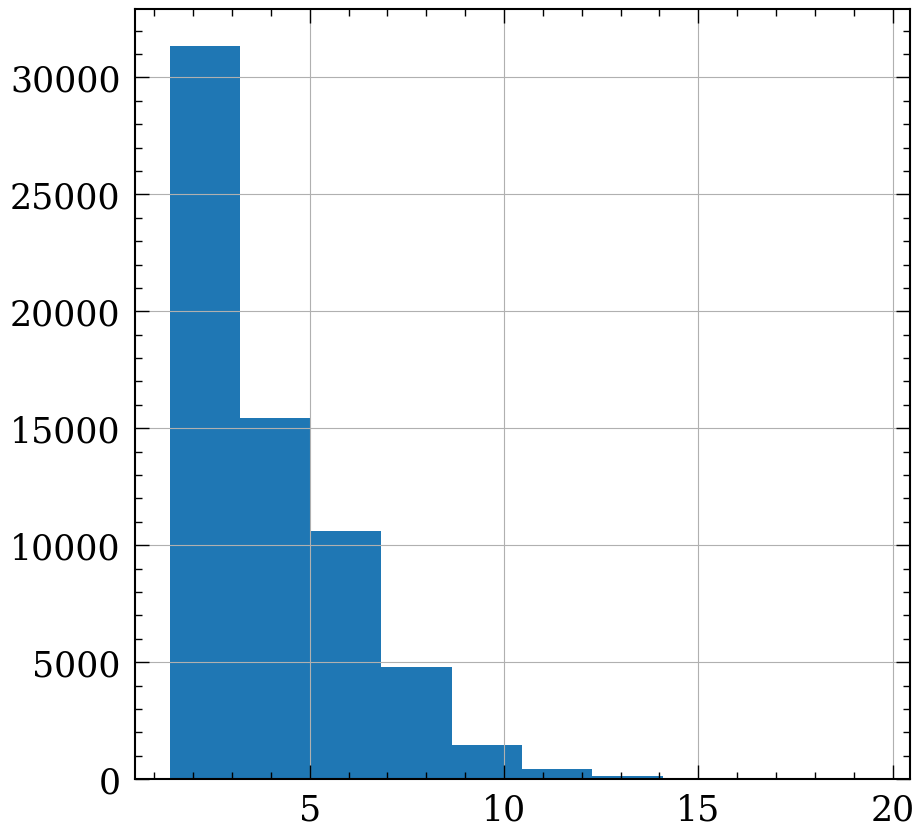

In [6]:
ztf['kin_age'].hist()

# Select even sampling of data

In [144]:
# select same amount based on teff
teffgrid = np.linspace(2900, 6500, 100)
protgrid = np.linspace(0, 2.3, 50)

numbpick = 10

agescat = np.zeros((len(teffgrid), len(protgrid)))

#tefflens = ztf_sing
count = 0 
for i in trange(len(teffgrid)-1):
    ztf_sing = ztf.loc[(ztf['teff_calc']>teffgrid[i])&(ztf['teff_calc']<teffgrid[i+1])]
    for j in range(len(protgrid)-1):
        ztf_sing_prot = ztf_sing.loc[(ztf_sing['Prot_log']>protgrid[j])&(ztf_sing['Prot_log']<protgrid[j+1])]
        if len(ztf_sing_prot)<10:
            continue
        else:
            agescat[i, j] = np.std(ztf_sing_prot['kin_age'].dropna())
            if count==0:
                ztf_pick = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))
                ztf_pick['age_err'] =  np.std(ztf_sing_prot['kin_age'].dropna())
            else:
                ztf_sing_selc = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))
                ztf_sing_selc['age_err'] = np.std(ztf_sing_prot['kin_age'].dropna())
                ztf_pick = pd.concat([ztf_pick, ztf_sing_selc])
            count = count+1
    
len(ztf_pick)

ztf_pick['cluster'] = 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 95.04it/s]


In [145]:
agescat = agescat[agescat!=0]
np.mean(agescat)

0.7456653906512941

In [146]:
ztf_pick['age_err'] = ztf_pick['age_err']+1

In [147]:
ztf_pick['Age'] = ztf_pick['kin_age']
ztf_pick['Age_err'] = ztf_pick['age_err']

print(len(ztf_pick))
ztf_pick = ztf_pick.dropna(subset=['teff_calc','Prot_log','Age','Age_err'])
print(len(ztf_pick))

ztf_pick = ztf_pick.loc[ztf_pick['Age']>1.4]
ztf_pick = ztf_pick.loc[ztf_pick['Prot_log']>0.7]
len(ztf_pick)

9590
9590


9590

In [148]:
print(len(ztf_pick))
ztf_sel = ztf_pick.dropna(subset=['teff_calc','Prot_log','Age','Age_err'])
print(len(ztf_sel))


9590
9590


# use random forest to get rid of outliers

In [149]:
ztf_sel = ztf_sel.reset_index(drop=True)

In [150]:
def RFregressor(df,testF,modelout=False,traind=0.8,ID_on='KID',X_train_ind=[],X_test_ind=[],target_var='Prot',target_var_err='Prot_err',chisq_out=False,MREout=False,n_estimators=100):
    """Train RF regression model and perform cross-validation test. 
    
    It uses scikit-learn Random Forest regressor model. All default hyper-parameters are taken from the scikit-learn model that user can change by adding in optional inputs. More details on hyper-parameters, see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html. To use the module to train a RF model to predict rotation period, input a pandas dataFrame with column names as well as a list of attribute names. 
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains all variables needed
      testF ([string list]): List of feature names used to train
      modelout (Optional [bool]): Whether to only output the trained model 
      traind (Optinal [float]): Fraction of data use to train, the rest will be used to perform cross-validation test (default 0.8)
      ID_on (Optional [string]): What is the star identifier column name (default 'KID'). If specified ID column does not exist, it will just take the index as ID
      X_train_ind (Optional [list]): List of *ID_on* for training set, if not specified, take random *traind* fraction of indexes from *ID_on* column
      X_test_ind (Optional [list]): List of *ID_on* for testing set, if not specified, take the remaining (1-*traind*) fraction of indexes from *ID_on* column that is not in the training set (*X_train_ind*)
      target_var (Optional [string]): Label column name (default 'Prot')
      target_var_err (Optional [string]): Label error column name (default 'Prot_err')
      chisq_out (optional [bool]): If true, only output average chisq value
      MREout (optional [bool]): If true, only output median relative error. If both *chisq_out* and *MREout* are true, then output only these two values
      
    Returns: 
      <RF model>, <pandas.Series>:
      
      :regr: Sklearn RF regressor model (attributes see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
      
      :<pandas.Series> containing:
       
        :actrualF ([string list]): Actrual features used
	:importance ([float list]): Impurity-based feature importance ordering as *actrualF*
	:ID_train ([list]): List of *ID_on* used for training set 
	:ID_test ([list]): List of *ID_on* used for testing set
	:predictp ([float list]): List of prediction on testing set
	:ave_chi ([float]): Average chisq on cross-validation (testing) set
	:MRE_val ([float]): Median relative error on cross-validation (testing) set
	:X_test ([matrix]): Matrix used to predict label values for testing set
	:y_test ([array-like]): Array of true label values of testing set
	:X_train ([matrix]): Matrix used to predict label values for training set
	:y_train ([array-like]): Array of true label values of training set
      
      
    """
   
    print('Simpliest example:\n regr,regr_outs = RFregressor(df,testF)\n')

    if len(X_train_ind)==0:
        print('Fraction of data used to train:',traind)
    else:
        print('Training KID specified!\n')
        print('Estimated fraction of data used to train:',float(len(X_train_ind))/float(len(df[target_var])))
    print('# of Features attempt to train:',len(testF))
    print('Features attempt to train:',testF)

    # check if there is an ID
    if ID_on not in df.columns:
        df[ID_on]=range(len(df))
        print('ID column not found, using index as ID!')

    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))
    
    featl_o=len(df[target_var]) # old feature length before dropping
    
    actrualF=[] # actrual feature used
    # fill in feature array
    lenX=0
    missingf=[]
    for i in df.columns:
        feature=df[i].values
        if (type(feature[0]) is not str) and (i in testF):
            if sum(np.isnan(feature))<0.1*featl_o:
                lenX=lenX+1
                actrualF.append(i)
            else:
                missingf.append(i)
            
    X=df[actrualF]
    X=X.replace([np.inf, -np.inf], np.nan)
    X=X.dropna()

    featl=np.shape(X)[0]
    #print(featl)
    print(str(featl_o)+' stars in dataframe!')
    if len(missingf)!=0:
        print('Missing features:',missingf)
    if (featl_o-featl)!=0:
        print('Missing '+ str(featl_o-featl)+' stars from null values in data!\n')

    print(str(featl)+' total stars used for RF!')
    

    #print(X_train_ind)

    if len(X_train_ind)==0:
        # output
        y=df[target_var][X.index].values
        y_err=df[target_var_err][X.index].values
        ID_ar=df[ID_on][X.index].values
        X=X.values
	
        Ntrain = int(traind*featl)
        # Choose stars at random and split.
        shuffle_inds = np.arange(len(y))
        np.random.shuffle(shuffle_inds)
        train_inds = shuffle_inds[:Ntrain]
        test_inds = shuffle_inds[Ntrain:]
	
        y_train, y_train_err, ID_train, X_train = y[train_inds], y_err[train_inds],ID_ar[train_inds],X[train_inds, :]
        y_test, y_test_err, ID_test, X_test = y[test_inds], y_err[test_inds],ID_ar[test_inds],X[test_inds, :]
	
        test_inds,y_test, y_test_err, ID_test, X_test=zip(*sorted(zip(test_inds,y_test, y_test_err, ID_test, X_test)))
        test_inds=np.array(test_inds)
        y_test=np.array(y_test)
        y_test_err=np.array(y_test_err)
        ID_test=np.array(ID_test)
        X_test=np.asarray(X_test)
	
    else:
        datafT=df.loc[X.index].loc[df[ID_on].isin(X_train_ind)]
        datafTes=df.loc[X.index].loc[df[ID_on].isin(X_test_ind)]
        y_train, y_train_err,X_train = datafT[target_var].values, datafT[target_var_err].values,X.loc[df[ID_on].isin(X_train_ind)].values
        y_test, y_test_err,X_test = datafTes[target_var].values, datafTes[target_var].values,X.loc[df[ID_on].isin(X_test_ind)].values
    print(str(len(y_train))+' training stars!')



    # run random forest
    regr = RandomForestRegressor(n_estimators=n_estimators)
    regr.fit(X_train, y_train)  
    
    

    # get the importance of each feature
    importance=regr.feature_importances_
    
    print('Finished training! Making predictions!')
    # make prediction
    predictp=regr.predict(X_test)
    print('Finished predicting! Calculating statistics!')
     
    # calculate chisq and MRE
    MRE_val=MRE(y_test,predictp,y_test_err)
    ave_chi=calcChi(y_test,predictp,y_test_err)

    print('Median Relative Error is:',MRE_val)
    print('Average chi^2 is:',ave_chi)
    
    if chisq_out:
        if MREout:
            print('Finished!')
            return ave_chi,MRE_val
        else:
            print('Finished!')
            return ave_chi
    elif MREout:
        print('Finished!')
        return MRE_val
    else:
        if len(X_train_ind)!=0:
            ID_train=datafT[ID_on].values
            ID_test=datafTes[ID_on].values
            ID_train=[int(i) for i in ID_train]
            ID_test=[int(i) for i in ID_test]
        print('Finished!')
        return regr,pd.Series([importance,actrualF,ID_train,ID_test,predictp,ave_chi,MRE_val,X_test,y_test,X_train,y_train],index=['importance','actrualF','ID_train','ID_test','prediction','ave_chi2','MRE','X_test','y_test','X_train','y_train'])

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['teff_calc', 'Prot_log']
9590 stars in dataframe!
9590 total stars used for RF!
7672 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.12355964230695599
Average chi^2 is: 0.5551317854927796
Finished!
9590
6693


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


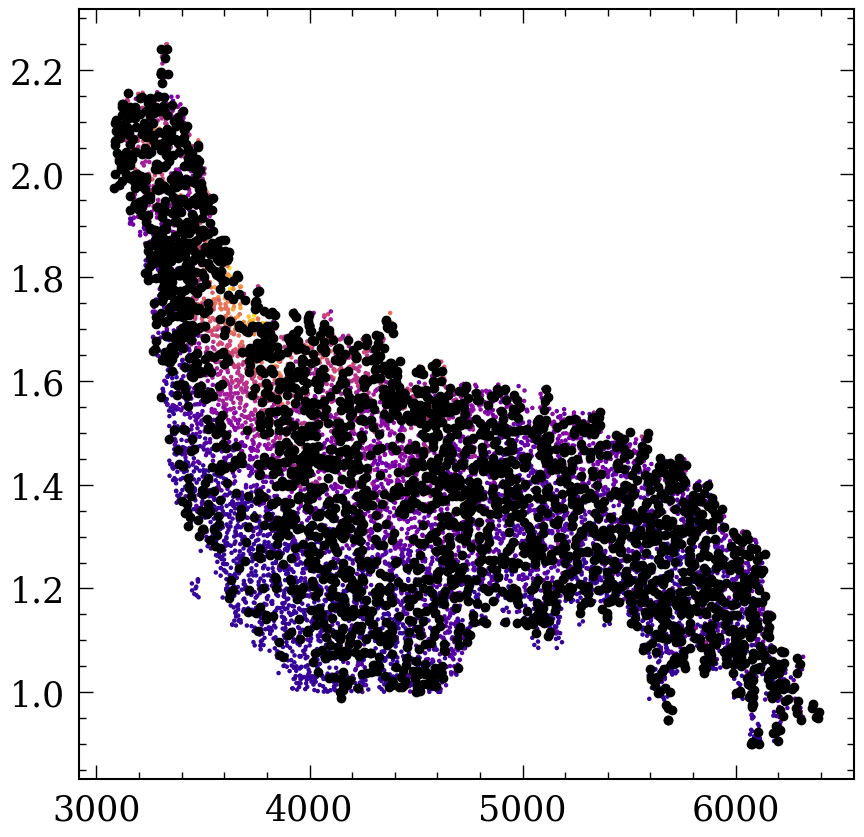

In [151]:
import Astraea
regr, regr_outs = RFregressor(ztf_sel, ['teff_calc','Prot_log'],
                                      target_var='Age', target_var_err='Age_err', 
                                      n_estimators=3)
ztf_sel['Age_prd'] = regr.predict(ztf_sel[regr_outs['actrualF']])
m = abs((ztf_sel['Age_prd']-ztf_sel['Age'])/ztf_sel['Age'])>0.1

plt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=5)
plt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'ko')

print(len(ztf_sel))
ztf_sel = ztf_sel[~m].reset_index(drop=True)
print(len(ztf_sel))

In [152]:
oc['cluster'] = 1
print(len(ztf_sel))
ztf_sel = pd.concat([ztf_sel, oc]).dropna(subset=['teff_calc','Prot_log','Age','Age_err'])
ztf_sel = ztf_sel.loc[ztf_sel['Age']>1.4]
print(len(ztf_sel))


6693
6836


# Train on age

## Create training set

0.1
6836 1.4005563018578204


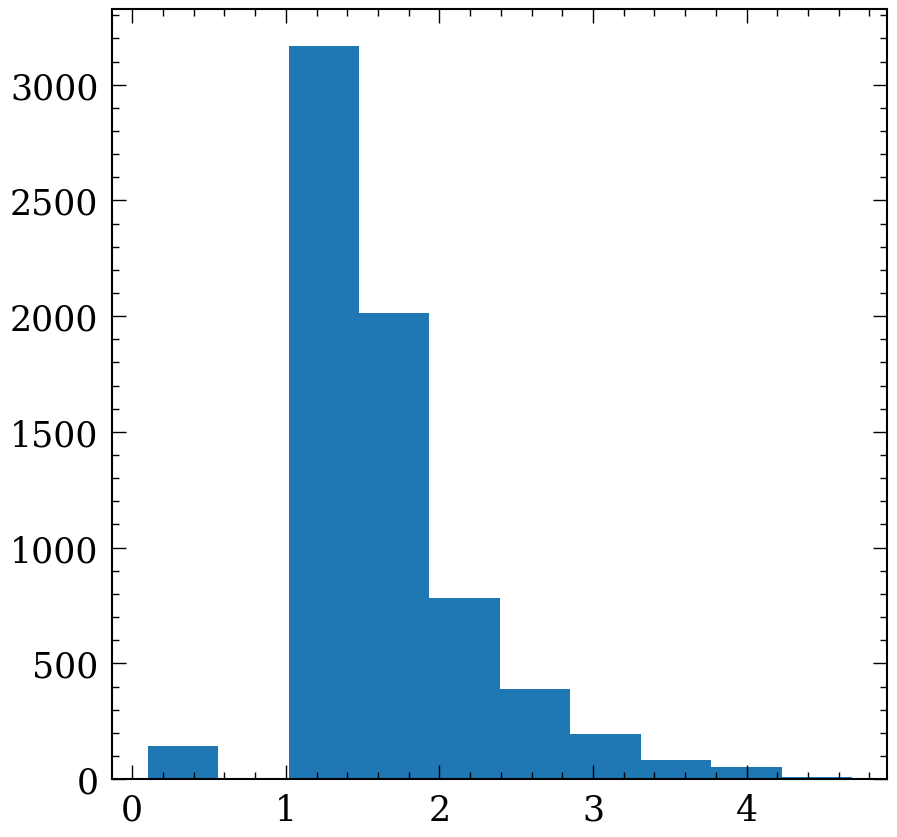

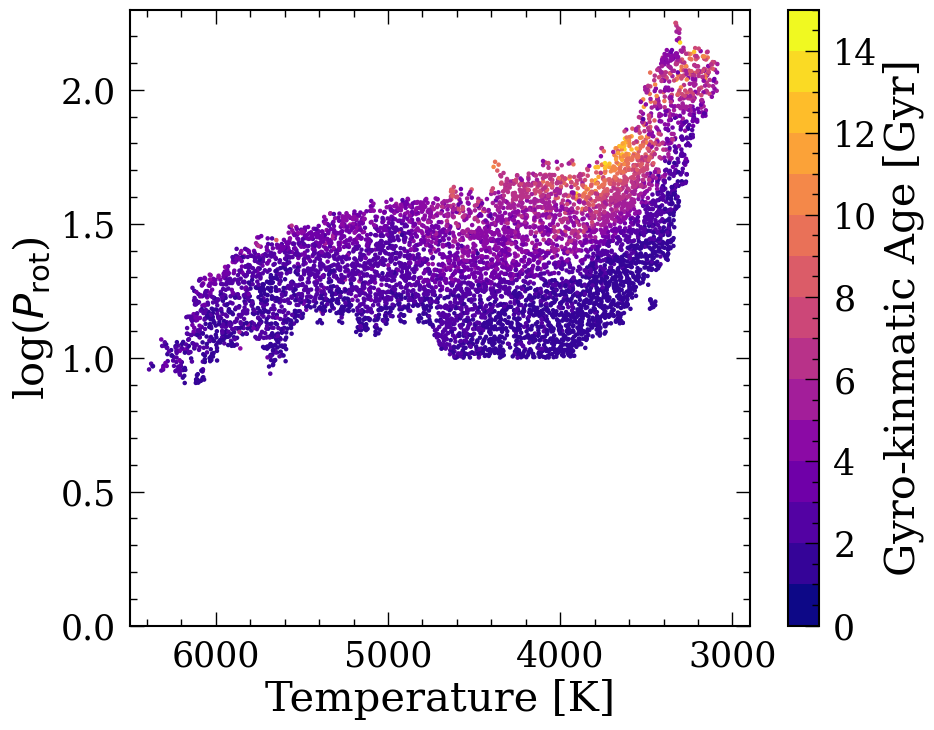

In [153]:
ndim = 2
X = np.array(([ztf_sel['teff_calc'].values, ztf_sel['Prot_log'].values])).T

yerr = ztf_sel['Age_err'].values
plt.hist(yerr)
print(min(yerr))

y = ztf_sel['Age'].values
plt.figure(figsize=(10,8))
plt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=5)
plt.xlim([2900,6500])
plt.ylim([0,2.3])
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('log($P_{\\rm rot}$)')
plt.colorbar(label='Gyro-kinmatic Age [Gyr]')

print(len(ztf_sel), min(ztf_sel['Age']))

3.8


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/1598360955.py:20: RankWarning: Polyfit may be poorly conditioned
  p = fitpoints(teff_med, prot_med, 51)


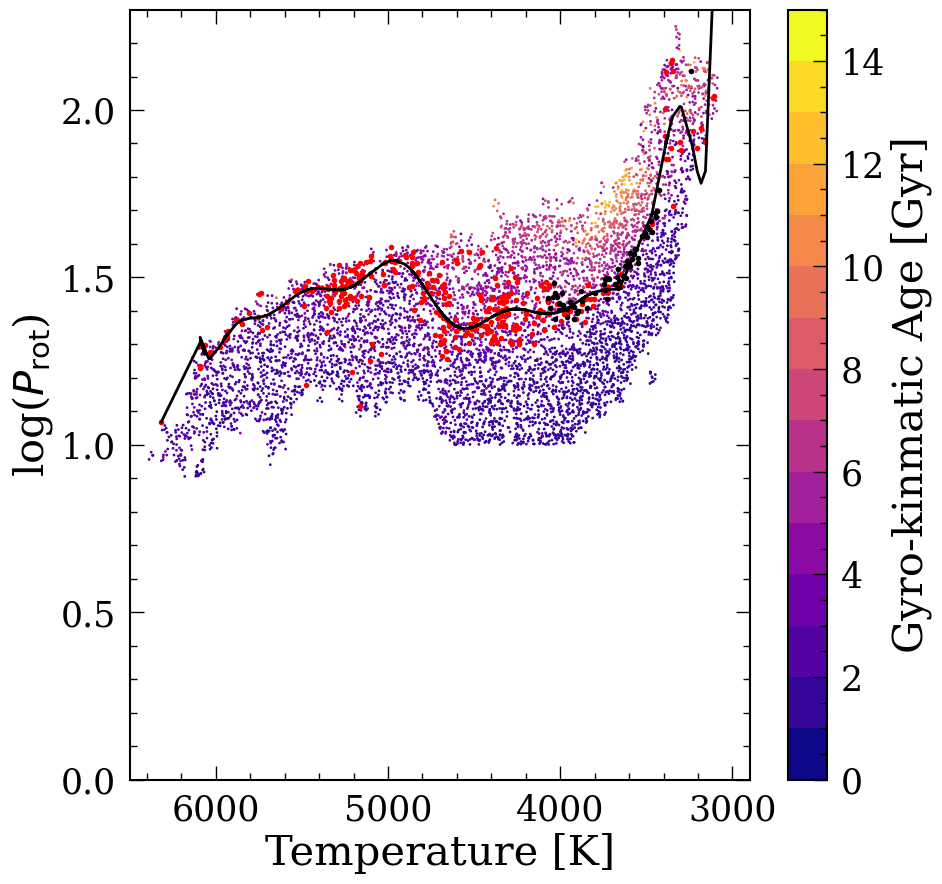

In [154]:

plt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=1)


selage = uniqage[7]
#selage = 14
print(selage)
m = abs(ztf_sel['kin_age']-selage)<0.2
plt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'r.')
teff_sort, prot_sort = zip(*sorted(zip(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m])))
teff_med, prot_med = movingMed_time(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m],
                                   200,100)



"""from scipy.ndimage import gaussian_filter1d
teff_med = gaussian_filter1d(teff_med, 0.1)
plt.plot(teff_med, prot_med, 'k-')"""

p = fitpoints(teff_med, prot_med, 51)
plt.plot(ztf_sel['teff_calc'][m], p(ztf_sel['teff_calc'][m]), 'k-')


oc_sing = oc.loc[oc['Age']==selage]
plt.plot(oc_sing['teff_calc'], np.log10(oc_sing['Prot']), 'k.')


plt.xlim([2900,6500])
plt.ylim([0,2.3])
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('log($P_{\\rm rot}$)')
plt.colorbar(label='Gyro-kinmatic Age [Gyr]')


# create prediction grid

In [155]:
# prediction grid
x_grid, y_grid = np.linspace(2900,6500,100), np.linspace(0,2.3,100)
x_, y_ = np.meshgrid(x_grid, y_grid)
y_true = np.zeros((len(y_grid),len(x_grid))) 
m_y = np.zeros((len(y_grid),len(x_grid)), dtype=bool) 

x_sing, y_sing, age_sing, age_sing_err = [], [], [], []
for i in range(len(y_grid)):
    ztf_sing = ztf_sel.loc[abs(ztf_sel['Prot_log']-y_grid[i])<np.diff(y_grid)[0]]
    for j in range(len(x_grid)):
        ztf_sing_new = ztf_sing.loc[abs(ztf_sing['teff_calc']-x_grid[j])<np.diff(x_grid)[0]]['kin_age'].dropna().values
        if len(ztf_sing_new)==0:
            continue 
        else:
            y_sing.append(y_grid[i])
            x_sing.append(x_grid[j])
            age_sing.append(np.median(ztf_sing_new))
            age_sing_err.append(np.std(ztf_sing_new))
            m_y[i,j] = True
            y_true[i,j] = np.median(ztf_sing_new)
            
X_pred = np.vstack((x_.flatten(), y_.flatten())).T


# Train correlated kernel

In [156]:
import jaxopt
from tinygp import GaussianProcess, kernels, transforms

def build_gp(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )

    return GaussianProcess(
        kernel, X, diag=yerr**2
    )

def build_gp_corr(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Cholesky.from_parameters(
        jnp.exp(params["log_scale"][:2]),
        params["log_scale"][2:],
        kernels.ExpSquared(),
    )
    return GaussianProcess(kernel, X, diag=yerr**2)


def neg_log_likelihood(params, X, y):
    gp = build_gp_corr(params, X)
    return -gp.log_probability(y)

theta_init = {
    "log_amp": 0.,
    "log_scale": np.array([1.,1.,1.])
}



In [157]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=X, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")


Final negative log likelihood: 10064.310746676132


In [158]:
soln.params

{'log_amp': DeviceArray(1.93483919, dtype=float64),
 'log_scale': DeviceArray([ 5.65750688, -2.11006885, -0.12330528], dtype=float64)}

In [159]:
def build_gp_uncorr(params):
    kernel = jnp.exp(params["log_amp"]) * transforms.Cholesky.from_parameters(
        jnp.exp(params["log_scale"][:2]),
        params["log_scale"][2:],
        kernels.ExpSquared(),
    )
    return GaussianProcess(kernel, X, diag=yerr**2)

uncorr_gp = build_gp_uncorr(soln.params)

In [160]:
y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/1269803207.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axes[0].pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max())
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/1269803207.py:12: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axes[1].pcolor(x_, y_, y_pred - y_true, vmin=0, vmax=15)


(0.5, 2.5)

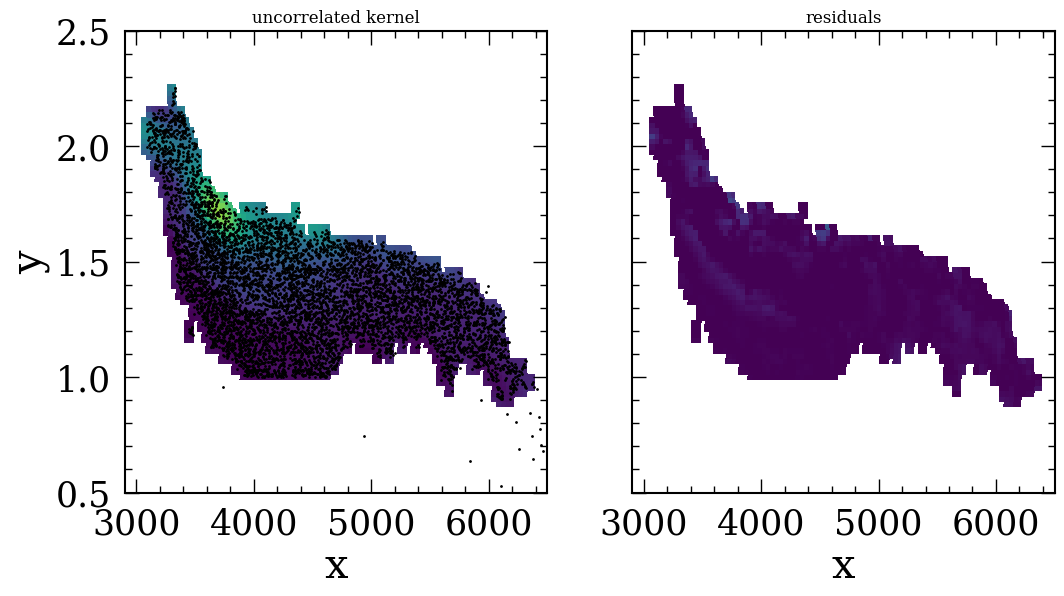

In [161]:
import numpy.ma as ma
x_ = ma.array(x_, mask = ~m_y)
y_ = ma.array(y_, mask = ~m_y)
y_pred = ma.array(y_pred, mask = ~m_y)
y_true = ma.array(y_true, mask = ~m_y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max())
axes[0].scatter(
    X[:, 0], X[:, 1], c='k', vmin=0, vmax=15, s=1
)
axes[1].pcolor(x_, y_, y_pred - y_true, vmin=0, vmax=15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("uncorrelated kernel")
axes[1].set_xlabel("x")
_ = axes[1].set_title("residuals")
axes[1].set_xlim([2900, 6500])
axes[0].set_xlim([2900, 6500])
axes[1].set_ylim([0.5,2.5])
axes[0].set_ylim([0.5,2.5])

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/976449247.py:2: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max(),


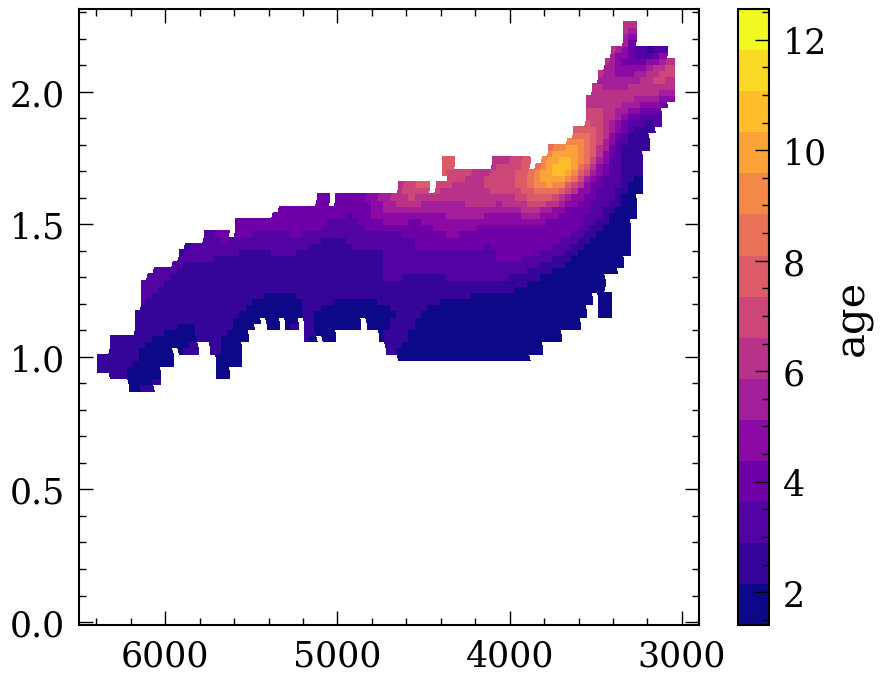

In [162]:
plt.figure(figsize=(10,8))
plt.pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max(),
          cmap=plt.get_cmap('plasma', 15))
plt.gca().invert_xaxis()
plt.colorbar(label='age')


In [163]:
teff_pred_sing = []
logprot_pred_sing = []
age_pred_sing = []

for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        teff_pred_sing.append(x_grid[i])
        logprot_pred_sing.append(y_grid[j])
        age_pred_sing.append(y_pred.data[j,i])
        

In [164]:
age_pred_sing = np.array(age_pred_sing)
logprot_pred_sing = np.array(logprot_pred_sing)
teff_pred_sing = np.array(teff_pred_sing)

In [165]:
min(age_pred_sing)

-0.0023498473788727027

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_4658/778996368.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max(),


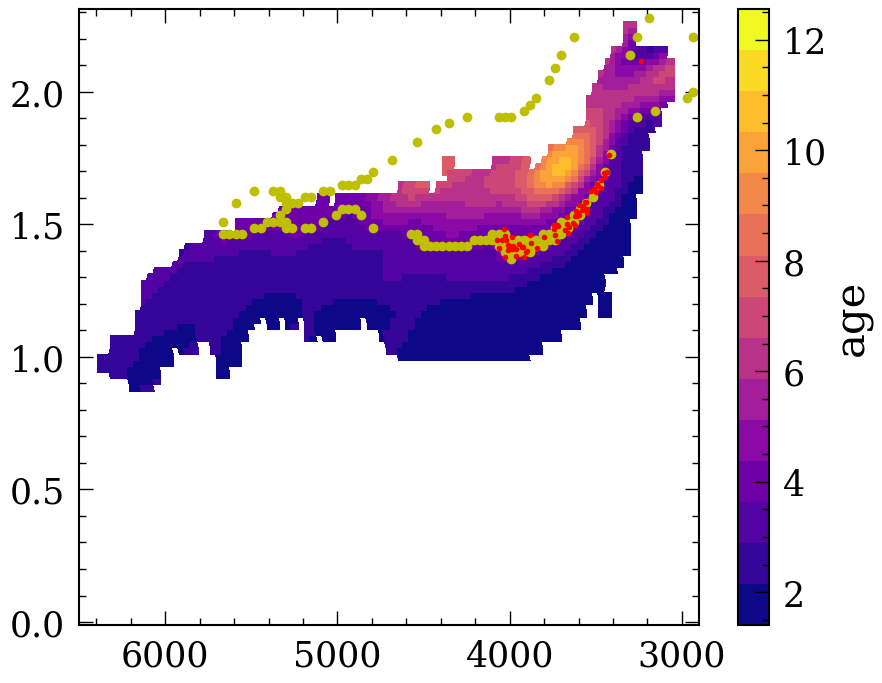

In [166]:
plt.figure(figsize=(10,8))
ageplot = uniqage[7]
#ageplot = 4

plt.pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max(),
          cmap=plt.get_cmap('plasma', 15))
m = (abs(age_pred_sing-ageplot)<0.1)
teff_plot, logprot_plot = zip(*sorted(zip(teff_pred_sing[m], logprot_pred_sing[m])))
plt.plot(teff_plot, logprot_plot, 'yo')
oc_sing = oc.loc[oc['Age']==ageplot]
plt.plot(oc_sing['teff_calc'], np.log10(oc_sing['Prot']), 'r.')

plt.gca().invert_xaxis()
plt.colorbar(label='age')


# predict age

-0.4697618703574075


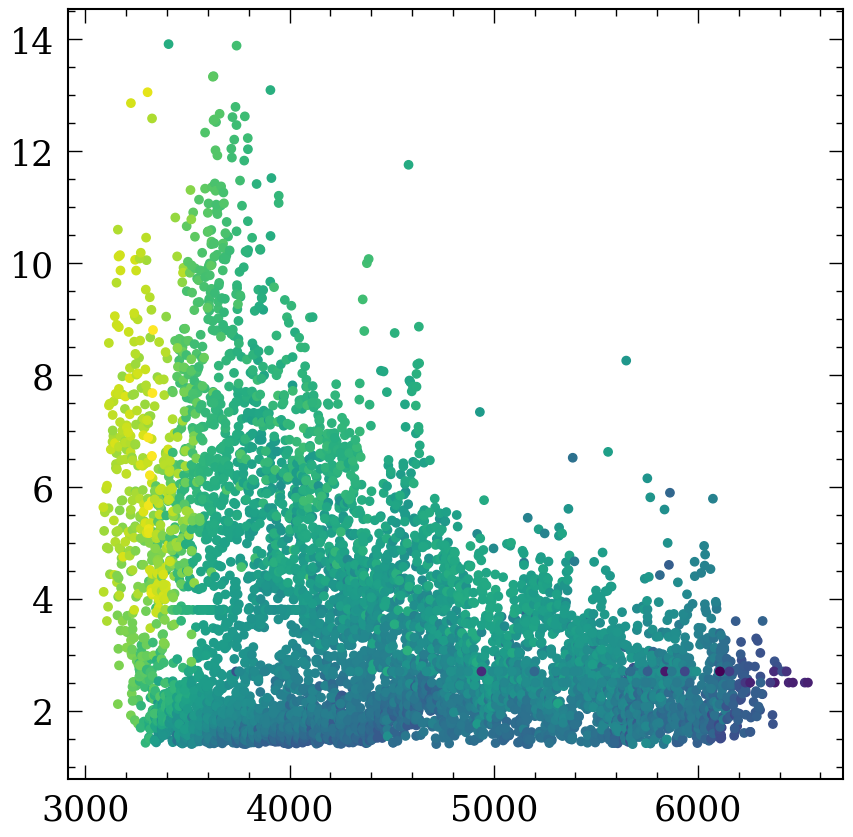

In [193]:
ndim = 2
X = np.array(([ztf_sel['teff_calc'].values, ztf_sel['Age'].values])).T

yerr = np.log10(ztf_sel['Prot'].values*0.1)
print(min(yerr))

y = ztf_sel['Prot_log'].values

plt.scatter(ztf_sel['teff_calc'].values, ztf_sel['Age'].values,
           c=ztf_sel['Prot_log'].values)

In [194]:
# prediction grid
x_grid, y_grid = np.linspace(2900,6500,100), np.linspace(1.4,13,20)
x_, y_ = np.meshgrid(x_grid, y_grid)
y_true = np.zeros((len(y_grid),len(x_grid))) 
m_y = np.zeros((len(y_grid),len(x_grid)), dtype=bool) 

x_sing, y_sing, age_sing, age_sing_err = [], [], [], []
for i in range(len(y_grid)):
    ztf_sing = ztf_sel.loc[abs(ztf_sel['Age']-y_grid[i])<np.diff(y_grid)[0]]
    for j in range(len(x_grid)):
        ztf_sing_new = ztf_sing.loc[abs(ztf_sing['teff_calc']-x_grid[j])<np.diff(x_grid)[0]]['Prot_log'].dropna().values
        if len(ztf_sing_new)==0:
            continue 
        else:
            y_sing.append(y_grid[i])
            x_sing.append(x_grid[j])
            age_sing.append(np.median(ztf_sing_new))
            age_sing_err.append(np.std(ztf_sing_new))
            m_y[i,j] = True
            y_true[i,j] = np.median(ztf_sing_new)
            
X_pred = np.vstack((x_.flatten(), y_.flatten())).T



In [195]:
import jaxopt
from tinygp import GaussianProcess, kernels, transforms

def build_gp(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )

    return GaussianProcess(
        kernel, X, diag=yerr**2
    )

def build_gp_corr(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Cholesky.from_parameters(
        jnp.exp(params["log_scale"][:2]),
        params["log_scale"][2:],
        kernels.ExpSquared(),
    )
    return GaussianProcess(kernel, X, diag=yerr**2)


def neg_log_likelihood(params, X, y):
    gp = build_gp_corr(params, X)
    return -gp.log_probability(y)

theta_init = {
    "log_amp": 0.,
    "log_scale": np.array([0.,0.,0.])
}




In [ ]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=X, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")



In [ ]:
soln.params

In [ ]:
y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

In [ ]:
import numpy.ma as ma
x_ = ma.array(x_, mask = ~m_y)
y_ = ma.array(y_, mask = ~m_y)
y_pred = ma.array(y_pred, mask = ~m_y)
y_true = ma.array(y_true, mask = ~m_y)

teff_pred_sing = []
logprot_pred_sing = []
age_pred_sing = []

for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        teff_pred_sing.append(x_grid[i])
        logprot_pred_sing.append(y_grid[j])
        age_pred_sing.append(y_pred.data[j,i])
        
        

In [ ]:
teff_pred_sing = np.array(teff_pred_sing)
logprot_pred_sing = np.array(logprot_pred_sing)
age_pred_sing = np.array(age_pred_sing)

In [ ]:
print(y_grid[3])
m = (logprot_pred_sing==y_grid[10])


In [ ]:
plt.hexbin(ztf_sel['teff_calc'], ztf_sel['Prot_log'], C=ztf_sel['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15), gridsize=50)
plt.gca().invert_xaxis()
plt.plot(teff_pred_sing[m], age_pred_sing[m])
